In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [2]:
ts = TimeSeries(key='0IN175LIOUOBEICW',output_format = 'pandas')
# Get json object with the intraday data and another with  the call's metadata
df, meta_data = ts.get_daily_adjusted(symbol='MMM', outputsize='full')
df = df.rename(columns = {'1. open':'Open','2. high':'High', '3. low':'Low', 
                 '4. close':'Close', '5. adjusted close':'Price', '6. volume':'Volume',
                 '7. dividend amount':'Dividends', '8. split coefficient':'Stock Splits'})
df.dropna(inplace=True)
# top should be olders
df = df.sort_values(by='date')
df.head()

,Open,High,Low,Close,Price,Volume,Dividends,Stock Splits
date,,,,,,,,
1999-11-01,95.13,96.19,93.75,94.00,26.704829,1091000.0,0.0,1.0
1999-11-02,94.75,96.13,94.44,94.88,26.954832,1395300.0,0.0,1.0
1999-11-03,94.63,95.69,94.31,94.50,26.846876,1230900.0,0.0,1.0
1999-11-04,94.88,95.88,94.56,94.75,26.917900,1211200.0,0.0,1.0
1999-11-05,95.50,96.25,95.25,95.69,27.184948,756400.0,0.0,1.0


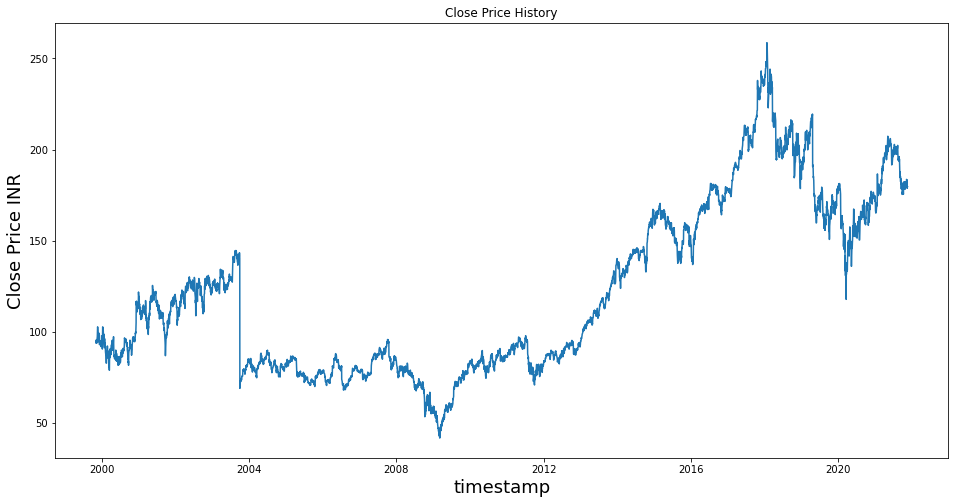

In [3]:
#drop nulls 
import seaborn as sns
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
#ax=sns.lineplot(data=df, x='timestamp',y='close', color="blue");
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()

# Data Processing

Convert to numpy array

In [4]:
#get dates and closing prices
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)
print(data.shape)

(5552, 1)


Scaling data to 0 to 1

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
print(scaled_data.shape)

(5552, 1)


Create x and y training data

In [6]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
print(type(x_train))
print(len(x_train))

<class 'list'>
4382


create x and y testing data

In [7]:
test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

Spliting for train and test

In [8]:
#convert into arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape
#same for training
x_test = np.array(x_test)
print(x_train.shape)
print(y_train.shape)

(4382, 60)
(4382,)


In [9]:
# Convert into 3 D
X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

x_train.shape

(4382, 60)

# Model

Building the Model

In [10]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Train with adam optimizer and mean squared error as loss function

In [11]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
137/137 [==============================] - 9s 68ms/step - loss: 0.0049
Epoch 2/10
137/137 [==============================] - 9s 67ms/step - loss: 0.0018
Epoch 3/10
137/137 [==============================] - 9s 68ms/step - loss: 0.0014
Epoch 4/10
137/137 [==============================] - 9s 67ms/step - loss: 0.0013
Epoch 5/10
137/137 [==============================] - 9s 66ms/step - loss: 0.0013
Epoch 6/10
137/137 [==============================] - 9s 66ms/step - loss: 0.0011
Epoch 7/10
137/137 [==============================] - 9s 66ms/step - loss: 9.9841e-04
Epoch 8/10
137/137 [==============================] - 9s 66ms/step - loss: 9.1895e-04
Epoch 9/10
137/137 [==============================] - 9s 67ms/step - loss: 9.1996e-04
Epoch 10/10
137/137 [==============================] - 9s 67ms/step - loss: 7.5594e-04


# Prediction

In [12]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [13]:
#### RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

6.135036229663816

Plotting Predictions

<ipython-input-14-81a866b139c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['Predictions'] = predictions #Visualize the data


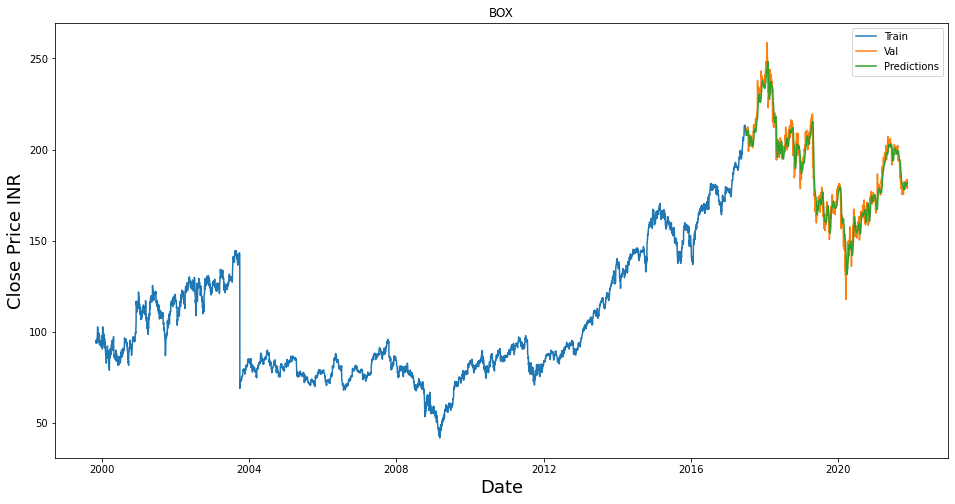

In [14]:
train = data[:training_data_len]
display = data[training_data_len:]
display['Predictions'] = predictions #Visualize the data
plt.figure(figsize=(16,8))
plt.title('BOX')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['Close'])
plt.plot(display['Close'])
plt.plot(display['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [15]:
display

,Close,Predictions
date,,
2017-06-28,210.62,210.704712
2017-06-29,207.85,210.843155
2017-06-30,208.19,210.756485
2017-07-03,209.83,210.451157
2017-07-05,209.76,209.996323
...,...,...
2021-11-16,183.37,180.858948
2021-11-17,183.34,181.154770
2021-11-18,178.77,181.490173
